In [1]:
# 导入libraries
import pandas as pd
from math import log2, e
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import re
from sklearn.impute import KNNImputer


# 导入外部文件
from TreeVis import createPlot
from KFold import kFoldTest
from SetAside import setAsideTest
from BootStrap import bootStrapTest

## 读取数据

In [2]:
# 读取数据
trainDataSet = pd.read_csv('data/titanic8120/train.csv')
trainDataSet.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


## 数据分布

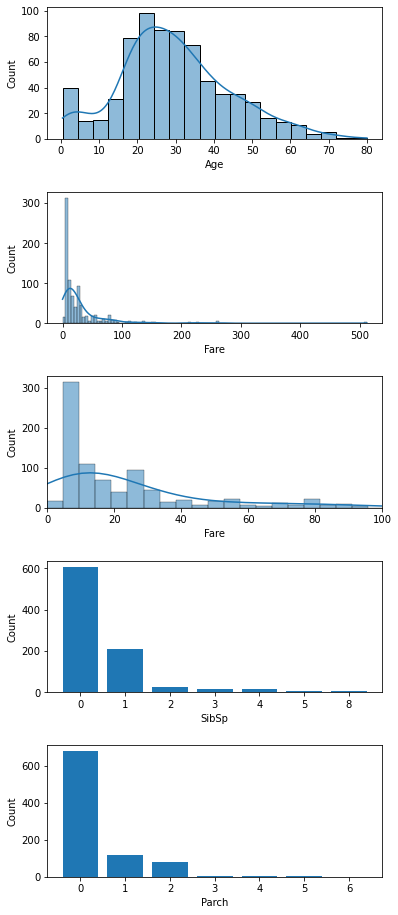

In [3]:
'''
连续型数据
Age Fare
'''
# 使用Seaborn绘制图像
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=[6, 16])
sns.histplot(trainDataSet['Age'], ax=ax1, kde=True)
sns.histplot(trainDataSet['Fare'], ax=ax2, kde=True)
sns.histplot(trainDataSet['Fare'], ax=ax3, kde=True)

# 统计并绘制SibSp的分布
d4 = trainDataSet['SibSp'].value_counts().sort_index()
ax4.bar(d4.index.map(str).tolist(), d4.tolist())

# 统计并绘制Parch的分布
d5 = trainDataSet['Parch'].value_counts().sort_index()
ax5.bar(d5.index.map(str).tolist(), d5.tolist())

# 调整图像的参数
ax3.set_xlim(0, 100) # 设置横坐标范围以放大fare在0-100的取值区间的分布
plt.subplots_adjust(wspace=0.4, hspace=0.4)
ax4.set_xlabel('SibSp', fontsize=10)      # 设置x轴标签
ax4.set_ylabel('Count', fontsize=10)    # 设置y轴标签
ax5.set_xlabel('Parch', fontsize=10)      # 设置x轴标签
ax5.set_ylabel('Count', fontsize=10)    # 设置y轴标签

plt.show()

从图中可以发现年龄的分布以18-40为主，因此分为 0-18(未成年), 19-40（青年）, 40-60（中年）, 60-80（老年）
Fare：0-20，20-40，40-60，60-

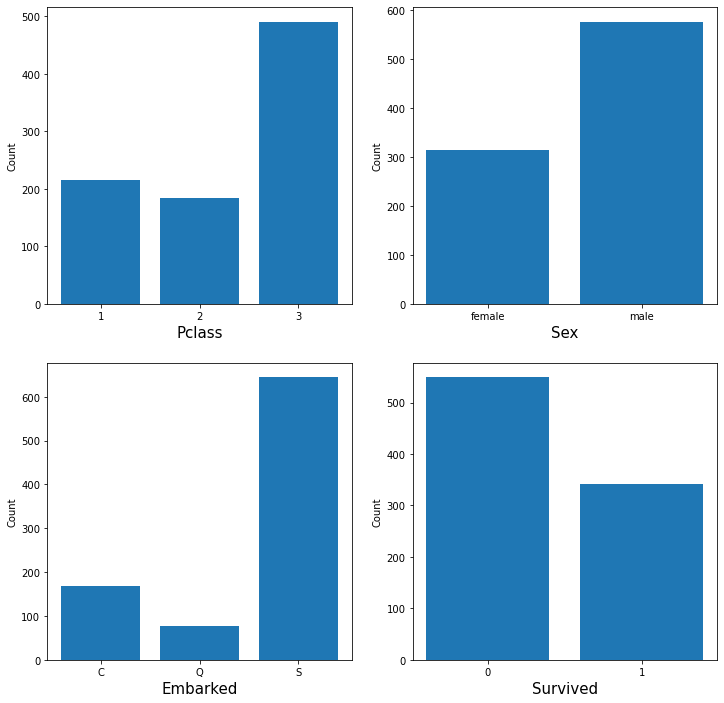

In [4]:
'''
离散型数据
Pclass Sex Embarked Survived
'''
# 绘制多子图
fig, axs = plt.subplots(2, 2, figsize=[12, 12])

# 在每一张子图上绘制柱状图
for i, label in enumerate(['Pclass', 'Sex', 'Embarked', 'Survived']):
    x = i // 2
    y = i % 2
    d = trainDataSet[label].value_counts().sort_index()

    # 绘制柱状图
    axs[x][y].bar(d.index.map(str).tolist(), d.tolist())
    axs[x][y].set_xlabel(label, fontsize=15)      # 设置x轴标签
    axs[x][y].set_ylabel('Count', fontsize=10)    # 设置y轴标签

plt.show()

In [5]:
trainDataSet.isnull().describe()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891,891,891,891,891,891,891,891,891,891,891,891
unique,1,1,1,1,1,2,1,1,1,1,2,2
top,False,False,False,False,False,False,False,False,False,False,True,False
freq,891,891,891,891,891,714,891,891,891,891,687,889


## 数据清洗

In [6]:
# 选取的特征值
FEATURE_LIST = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Survived']

# 转换测试集，目的是对测试集做同样的操作
def transform_df(dataframe, feature_lst):
    # 保留需要的特征
    dataframe = dataframe.loc[:, feature_lst]

    # 将性别转换为数字（scikit-learn要求）
    dataframe.loc[:, 'Sex'] = (dataframe['Sex'] == 'male').astype('int')

    # 连续数据离散化
    def pcAge(age):
        if age <= 18:
            return 0
        elif 18 < age <= 40:
            return 2
        elif 41 < age <= 60:
            return 3
    def pcFare(fare):
        if fare <= 20:
            return 0
        elif 20 < fare <= 500:
            return 1
    def pcEmbarked(embarked):
        if embarked == 'S':
            return 0
        elif embarked == 'C':
            return 1
        elif embarked == 'Q':
            return 2
    def pcSibSp(sibsp):
        if sibsp == 0:
            return 0
        elif sibsp > 0:
            return 1
    def pcParch(parch):
        if parch == 0:
            return 0
        elif parch > 0:
            return 1
    dataframe.loc[:, 'Age'] = dataframe['Age'].agg(pcAge)
    dataframe.loc[:, 'Fare'] = dataframe['Fare'].agg(pcFare)
    dataframe.loc[:, 'Embarked'] = dataframe['Embarked'].agg(pcEmbarked)
    dataframe.loc[:, 'SibSp'] = dataframe['SibSp'].agg(pcSibSp)
    dataframe.loc[:, 'Parch'] = dataframe['Parch'].agg(pcParch)

    # 用KNN算法填充空白值
    imputer = KNNImputer(n_neighbors=5)
    imputed = imputer.fit_transform(dataframe)
    dataframe = pd.DataFrame(imputed, columns=dataframe.columns)

    dataframe = dataframe.astype(int)
    return dataframe

trainDataSet = transform_df(trainDataSet, FEATURE_LIST)
trainDataSet.head(3)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,3,1,2,1,0,0,0,0
1,1,0,2,1,0,1,1,1
2,3,0,2,0,0,0,0,1


In [7]:
trainDataSet.isnull().apply(lambda x:x.value_counts()).fillna(0)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
False,891,891,891,891,891,891,891,891


## 选取特征子集

In [8]:
# 选取特征子集
FEATURE_LIST = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Survived']

trainDataSet = trainDataSet[FEATURE_LIST]
trainDataSet.head(3)

,Pclass,Sex,Age,SibSp,Parch,Survived
0,3,1,2,1,0,0
1,1,0,2,1,0,1
2,3,0,2,0,0,1


## ID3决策树

In [9]:
# 留出法
from ID3 import createID3Tree, classifyID3DF

# 将训练数据集转换为所需要的格式
ac, matrix = setAsideTest(createID3Tree, classifyID3DF, trainDataSet, roundNum=10, proportion=0.2)
print('准确率为: {:.03f}%'.format(ac * 100))
matrix

准确率为: 82.599%


,Pre:1,Pre:0
Real:1,24.92,13.50
Real:0,3.90,57.68


In [10]:
# K-Fold检验
from ID3 import createID3Tree, classifyID3DF

# 将训练数据集转换为所需要的格式
ac, matrix = kFoldTest(createID3Tree, classifyID3DF, trainDataSet, curNum=len(trainDataSet))
print('准确率为: {:.03f}%'.format(ac * 100))
matrix

准确率为: 80.808%


,Pre:1,Pre:0
Real:1,24.47,13.92
Real:0,5.27,56.34


In [11]:
# 自助法
from ID3 import createID3Tree, classifyID3DF

# 将训练数据集转换为所需要的格式
ac, matrix = bootStrapTest(createID3Tree, classifyID3DF, trainDataSet, sampleNum=len(trainDataSet), roundNum=10)
print('准确率为: {:.03f}%'.format(ac * 100))
matrix

准确率为: 80.611%


,Pre:1,Pre:0
Real:1,24.18,12.87
Real:0,6.51,56.43


## 决策树可视化

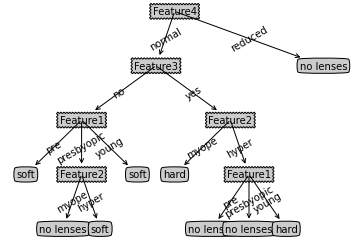

In [12]:
plotTreeDataSet = []
with open('./data/lenses.txt', 'r') as f:
    for row in f.readlines():
        row = row[:-1]
        row = row.split('\t')
        plotTreeDataSet.append(row)
id3Tree = createID3Tree(plotTreeDataSet, ['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5'])
createPlot(id3Tree)

## 优化的id3决策树

In [13]:
from ID3 import createID3Tree, classifyID3DF, createID3TreeImproved, classifyID3ImprovedDF
from Func import checkPrecision

# 分离性别为0和1的数据集，其中性别为0的数据用于训练，性别为1的数据用于验证
trainSubDataSet = trainDataSet[trainDataSet['Age'] != 1]
testSubDataSet = trainDataSet[trainDataSet['Age'] == 1]
testRealLabels = testSubDataSet['Survived']

# 使用原ID3决策树算法进行训练并预测
id3Tree = createID3Tree(trainSubDataSet.values.tolist(), trainSubDataSet.columns.tolist()[:-1])
predictResult = classifyID3DF(id3Tree, testSubDataSet)['Predict']
ac, matrix = checkPrecision(predictResult, testRealLabels)
print('在原ID3决策树中的准确率：{:.01f}%'.format(ac * 100))

print('-------------------------------------------')

# 使用改进后的ID3决策树算法进行训练并预测
id3Tree = createID3TreeImproved(trainSubDataSet.values.tolist(), trainSubDataSet.columns.tolist()[:-1])
predictResult = classifyID3ImprovedDF(id3Tree, testSubDataSet)['Predict']
ac, matrix = checkPrecision(predictResult, testRealLabels)
print('在Improved ID3决策树中的准确率：{:.01f}%'.format(ac * 100))

在原ID3决策树中的准确率：2.9%
-------------------------------------------
在Improved ID3决策树中的准确率：48.6%


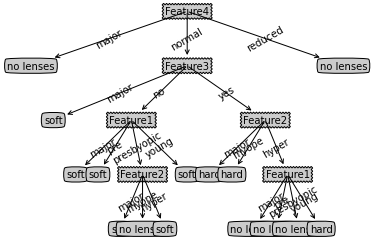

In [14]:
plotTreeDataSet = []
with open('./data/lenses.txt', 'r') as f:
    for row in f.readlines():
        row = row[:-1]
        row = row.split('\t')
        plotTreeDataSet.append(row)
id3Tree = createID3TreeImproved(plotTreeDataSet, ['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5'])
createPlot(id3Tree)

## C4.5决策树

> 问题：用了信息增益率的话就没办法和整个dataset进行比较了

In [15]:
# 留出法
from C45 import createC45Tree, classifyC45DF

# 将训练数据集转换为所需要的格式
ac, matrix = setAsideTest(createC45Tree, classifyC45DF, trainDataSet, roundNum=10, proportion=0.2)
print('准确率为: {:.03f}%'.format(ac * 100))
matrix

准确率为: 82.429%


,Pre:1,Pre:0
Real:1,25.54,12.88
Real:0,4.69,56.89


In [16]:
# K-Fold
from C45 import createC45Tree, classifyC45DF

# 将训练数据集转换为所需要的格式
ac, matrix = kFoldTest(createC45Tree, classifyC45DF, trainDataSet, curNum=10)
print('准确率为: {:.03f}%'.format(ac * 100))
matrix

准确率为: 80.919%


,Pre:1,Pre:0
Real:1,24.36,14.03
Real:0,5.05,56.56


In [17]:
# BootStrap
from C45 import createC45Tree, classifyC45DF

# 将训练数据集转换为所需要的格式
ac, matrix = bootStrapTest(createC45Tree, classifyC45DF, trainDataSet, sampleNum=len(trainDataSet), roundNum=10)
print('准确率为: {:.03f}%'.format(ac * 100))
matrix

准确率为: 81.154%


,Pre:1,Pre:0
Real:1,24.68,13.19
Real:0,5.66,56.48


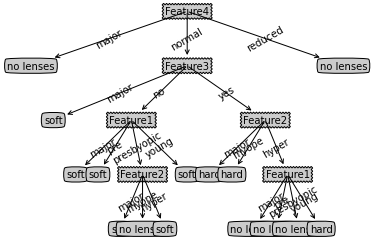

In [18]:
plotTreeDataSet = []
with open('./data/lenses.txt', 'r') as f:
    for row in f.readlines():
        row = row[:-1]
        row = row.split('\t')
        plotTreeDataSet.append(row)
c45Tree = createC45Tree(plotTreeDataSet, ['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5'])
createPlot(c45Tree)

## Cart决策树

In [19]:
from Cart import createCartTree, classifyCartDF, cartSetAsideTest

# 将训练数据集转换为所需要的格式
ac, matrix = setAsideTest(createCartTree, classifyCartDF, trainDataSet, roundNum=10, proportion=0.2)
print('准确率为: {:.03f}%'.format(ac * 100))
matrix

准确率为: 80.508%


,Pre:1,Pre:0
Real:1,24.63,13.79
Real:0,5.71,55.88


In [20]:
from Cart import createCartTree, classifyCartDF, cartKFoldTest

# 将训练数据集转换为所需要的格式
ac, matrix = cartKFoldTest(createCartTree, classifyCartDF, trainDataSet, curNum=10)
print('准确率为: {:.03f}%'.format(ac * 100))
matrix

准确率为: 81.145%


,Pre:1,Pre:0
Real:1,24.58,13.81
Real:0,5.05,56.57


In [21]:
from Cart import createCartTree, classifyCartDF, cartBootStrapTest

# 将训练数据集转换为所需要的格式
ac, matrix = cartBootStrapTest(createCartTree, classifyCartDF, trainDataSet, sampleNum=len(trainDataSet), roundNum=10)
print('准确率为: {:.03f}%'.format(ac * 100))
matrix

准确率为: 81.765%


,Pre:1,Pre:0
Real:1,25.41,13.27
Real:0,4.96,56.35


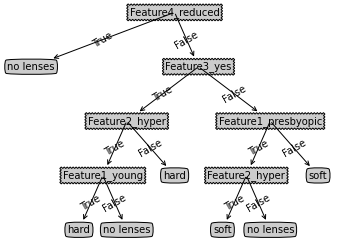

In [22]:
plotTreeDataSet = []
with open('./data/lenses.txt', 'r') as f:
    for row in f.readlines():
        row = row[:-1]
        row = row.split('\t')
        plotTreeDataSet.append(row)
cartTree = createCartTree(plotTreeDataSet, ['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5'])
createPlot(cartTree)

## 剪枝

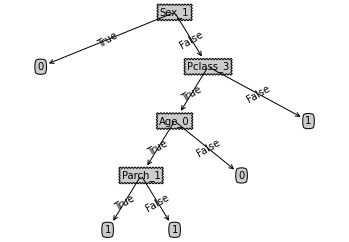

In [23]:
# 预剪枝
from CartPrePruning import createCartTree
from SetAside import setAside

# 划分数据集和验证集
trainSubDataSet, testSubDataSet = setAside(trainDataSet, 0.5)
cartTree = createCartTree(trainSubDataSet.values.tolist(), testSubDataSet.values.tolist(), trainSubDataSet.columns.tolist())

createPlot(cartTree)

后剪枝后，Cart树检验验证集的正确率：81.262


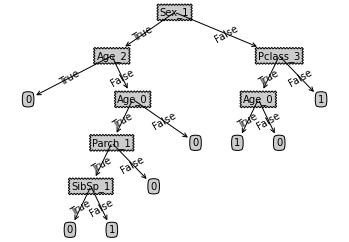

In [36]:
# 后剪枝
from CartPostPruning import createCartTree, classifyCartDF
from BootStrap import bootStrap

# 将训练集和验证集同时输入创建Cart预剪枝树
trainSubDataSet, testSubDataSet = bootStrap(trainDataSet, len(trainSubDataSet))
trainSubDataSet, trainTestSubDataSet = bootStrap(trainSubDataSet, len(trainSubDataSet))
cartTree, _a, _n = createCartTree(trainSubDataSet.values.tolist(), trainTestSubDataSet.values.tolist(), trainSubDataSet.columns.tolist(), giniThreshold=0.01)


# 验证后剪枝后的准确率
predictResult = classifyCartDF(cartTree, testSubDataSet)
accuracy, matrix = checkPrecision(predictResult['Predict'], predictResult['Survived'])
print('后剪枝后，Cart树检验验证集的正确率：{:.03f}'.format(accuracy * 100))

createPlot(cartTree)
plt.show()

## 存储树

In [25]:
import pickle

# 存储决策树
def storeTree(tree, fileName):
    # 打开文件fileName，使用dump函数将tree文件存入该文件中
    with open(fileName, 'wb+') as f:
        pickle.dump(tree, f)

# 从文件获取决策树
def grabTree(fileName):
    # 打开文件fileName，使用load函数从文件读取tree
    with open(fileName, 'rb+') as f:
        tree = pickle.load(f)
    return tree

In [26]:
# 存储cart树
storeTree(cartTree, 'tree.pkl')

cartTree = 0

# 读取cart树
cartTree = grabTree('tree.pkl')

print(cartTree)

{'Sex_1': {True: {'Pclass_3': {True: {'Age_1': {True: 0, False: {'Parch_1': {True: {'SibSp_1': {True: 0, False: {'Age_2': {True: 0, False: 1}}}}, False: 0}}}}, False: {'Pclass_2': {True: {'SibSp_1': {True: {'Age_0': {True: 1, False: 0}}, False: {'Age_1': {True: 0, False: {'Parch_1': {True: 1, False: 0}}}}}}, False: 0}}}}, False: {'Pclass_3': {True: {'Age_0': {True: {'SibSp_1': {True: {'Parch_1': {True: 0, False: 1}}, False: {'Parch_1': {True: 0, False: 1}}}}, False: {'Parch_1': {True: {'Age_2': {True: 0, False: 1}}, False: 0}}}}, False: 1}}}}


## Scikit-Learn

## 原始数据集

In [27]:
originalDataSet = pd.read_csv('./data/titanic8120/train.csv')
originalDataSet.head(3)

# 去除对预测无用数据集
originalDataSet.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

# 将各列数据映射为int数据类型
originalDataSet['Sex'] = (originalDataSet['Sex'] == 'male').astype('int')

labels = originalDataSet['Embarked'].unique().tolist()
originalDataSet['Embarked'] = originalDataSet['Embarked'].apply(lambda n: labels.index(n))

# 使用K-临近填充空值
knn = KNNImputer(n_neighbors=3)
originalDataSet = pd.DataFrame(knn.fit_transform(originalDataSet), columns=originalDataSet.columns)
originalDataSet = originalDataSet.astype(int)
originalDataSet.head(3)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,1,22,1,0,7,0
1,2,1,1,0,38,1,0,71,1
2,3,1,3,0,26,0,0,7,0


In [28]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# 分离数据和class，训练集和测试集
labels = originalDataSet['Survived'].values
values = originalDataSet.drop(['Survived'], axis=1).values

trainValues, testValues, trainLabels, testLabels = train_test_split(values, labels, test_size=0.2)

# 构建决策树
tree = DecisionTreeClassifier()
tree.fit(trainValues, trainLabels)

# 测试决策树得分
trainScore = tree.score(trainValues, trainLabels)
testScore = tree.score(testValues, testLabels)
print('经过验证:\n训练准确率高达{:.02f}%\n验证准确率高达{:.02f}%'.format(trainScore * 100, testScore * 100))

经过验证:
训练准确率高达100.00%
验证准确率高达74.30%


## 离散化后的准确率

In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold

trainFeatures = trainDataSet.columns.tolist()[:-1]
classLabel = 'Survived'

# 构建K-fold交叉验证
kf = KFold(n_splits=5, shuffle=True, random_state=6)

avgTrainScore = 0
avgTestScore = 0
for trainIndex, testIndex in kf.split(trainDataSet):
    # 分离训练集和测试集
    trainSubDataSet = trainDataSet.iloc[trainIndex]
    testSubDataSet = trainDataSet.iloc[testIndex]

    trainValues = trainSubDataSet[trainFeatures].values
    trainLabels = trainSubDataSet[classLabel].values
    testValues = testSubDataSet[trainFeatures].values
    testLabels = testSubDataSet[classLabel].values

    # 构建决策树
    tree = DecisionTreeClassifier()
    tree.fit(trainValues, trainLabels)

    # 测试模型得分
    trainScore = tree.score(trainValues, trainLabels)
    testScore = tree.score(testValues, testLabels)

    avgTrainScore += trainScore
    avgTestScore += testScore

# 计算平均得分
avgTrainScore /= 5
avgTestScore /= 5

print('经过5折验证:\n训练准确率高达{:.02f}%\n验证准确率高达{:.02f}%'.format(avgTrainScore * 100, avgTestScore * 100))

经过5折验证:
训练准确率高达83.19%
验证准确率高达80.47%


最高训练准确率: 90.53%，此时maxDepth=9 
最高验证准确率: 78.36%，此时maxDepth=5


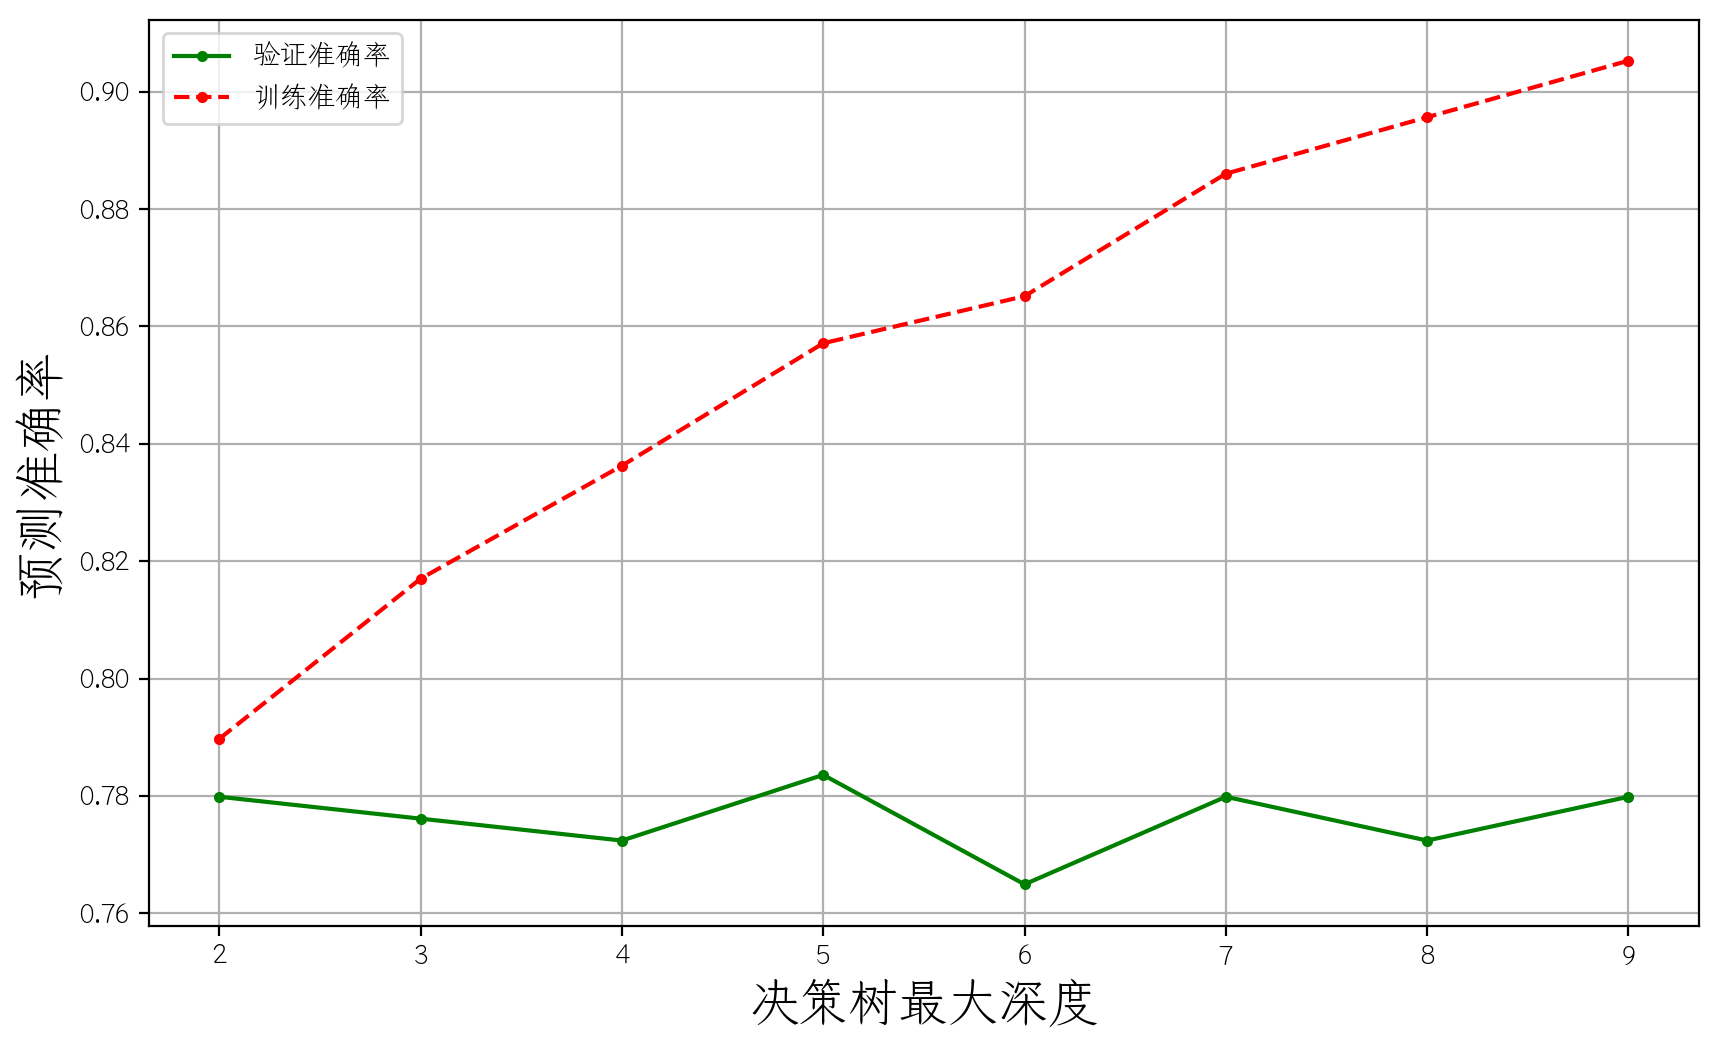

In [30]:
# 离散化前
from sklearn.model_selection import train_test_split
import numpy as np

# 分离特征和class，训练集和测试集
trainValues, testValues, trainLabels, testLabels = train_test_split(originalDataSet[trainFeatures].values, originalDataSet[classLabel].values, test_size=0.3)

# 对每一个maxDepth计算模型准确率的模型
def depthTest(maxDepth):
    tree = DecisionTreeClassifier(max_depth=maxDepth)
    tree.fit(trainValues, trainLabels)

    trainScore = tree.score(trainValues, trainLabels)
    testScore = tree.score(testValues, testLabels)

    return (trainScore, testScore)

# 计算不同最大深度时模型的正确率
depthRange = range(2, 10)
scores = [depthTest(maxDepth) for maxDepth in depthRange]
trainScores = [score[0] for score in scores]
testScores = [score[1] for score in scores]

# 输出最高训练准确率和最高验证准确率
maxTrainScoreIndex = np.argmax(trainScores)
maxTestScoreIndex = np.argmax(testScores)
maxTrainScore = trainScores[maxTrainScoreIndex]
maxTestScore = testScores[maxTestScoreIndex]
print('最高训练准确率: {:.02f}%，此时maxDepth={} \n最高验证准确率: {:.02f}%，此时maxDepth={}'.format(maxTrainScore * 100, depthRange[maxTrainScoreIndex], maxTestScore * 100, depthRange[maxTestScoreIndex]))

# 绘制预测准确率随树的深度变化曲线
plt.rcParams['font.sans-serif'] = ['TsangerMingkai']

plt.figure(figsize=(10, 6), dpi=200)
plt.grid()
plt.xlabel('决策树最大深度',fontsize=18)
plt.ylabel('预测准确率', fontsize=18)
plt.plot(depthRange, testScores, '.g-', label='验证准确率')
plt.plot(depthRange, trainScores, '.r--', label='训练准确率')
plt.legend()
plt.show()

最高训练准确率: 83.63%，此时maxDepth=6 
最高验证准确率: 80.22%，此时maxDepth=6


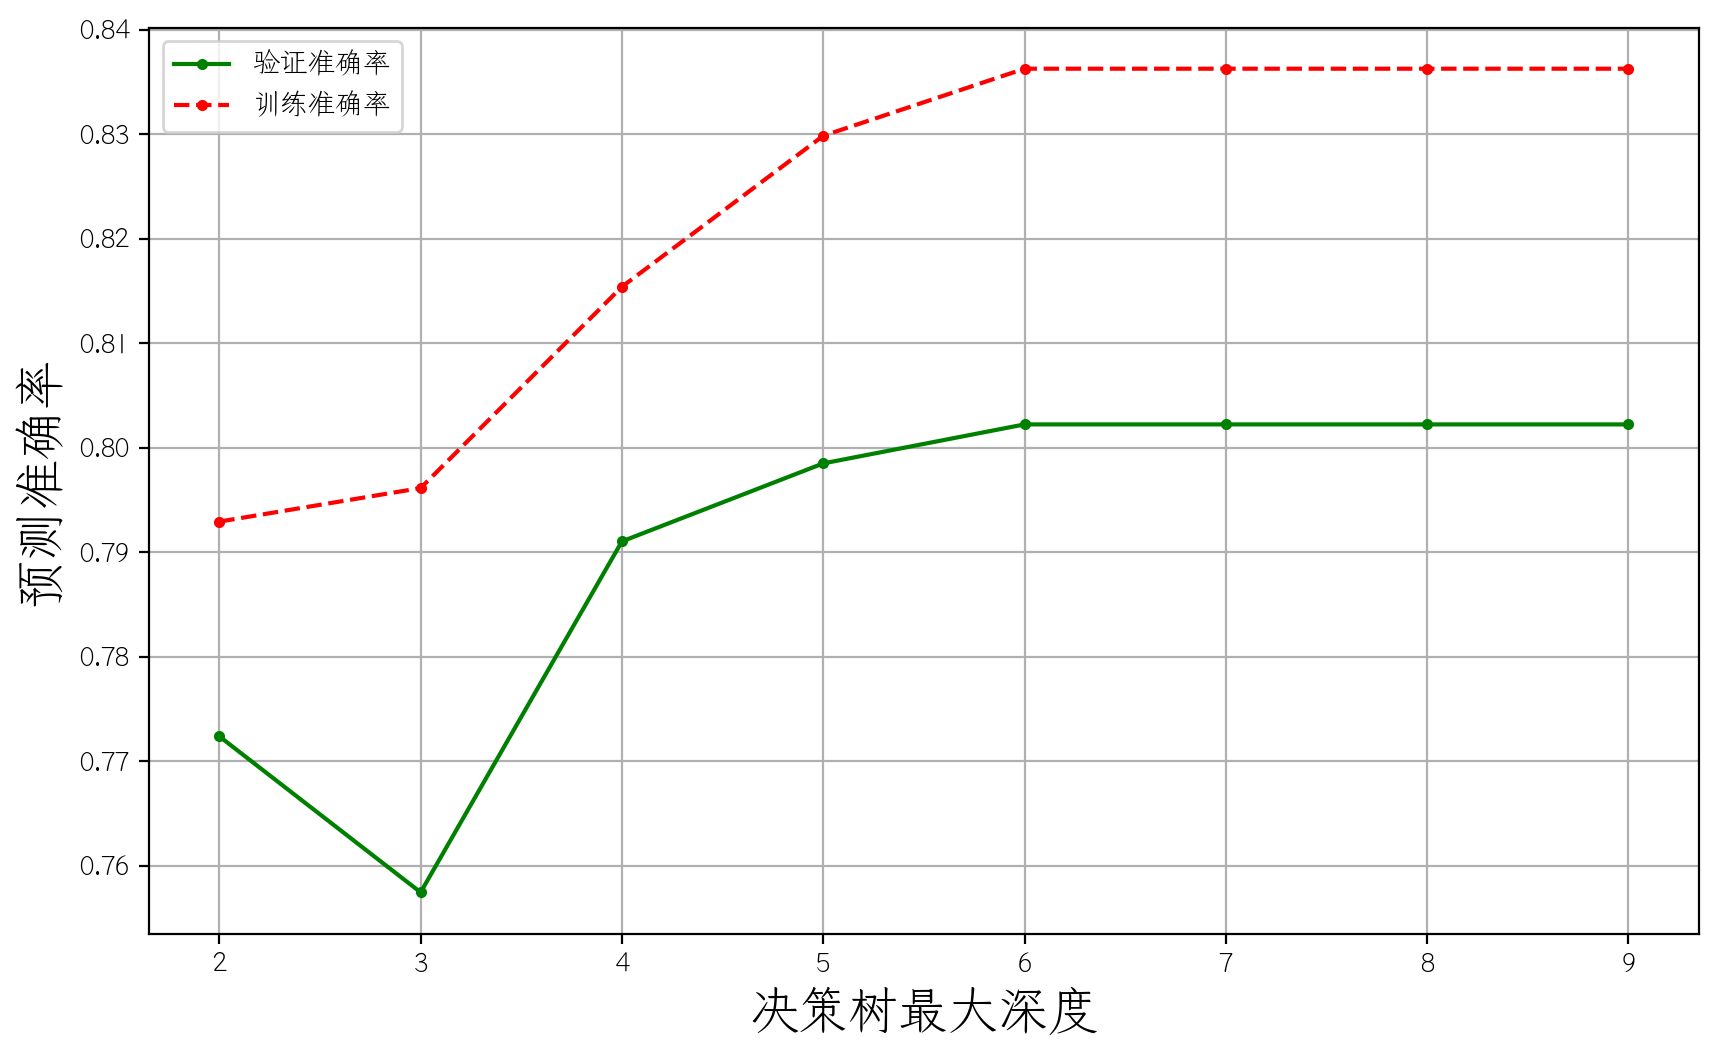

In [31]:
# 离散化后
from sklearn.model_selection import train_test_split
import numpy as np

# 分离特征和class，训练集和测试集
trainValues, testValues, trainLabels, testLabels = train_test_split(trainDataSet[trainFeatures].values, trainDataSet[classLabel].values, test_size=0.3)

# 对每一个maxDepth计算模型准确率的模型
def depthTest(maxDepth):
    tree = DecisionTreeClassifier(max_depth=maxDepth)
    tree.fit(trainValues, trainLabels)

    trainScore = tree.score(trainValues, trainLabels)
    testScore = tree.score(testValues, testLabels)

    return (trainScore, testScore)

# 计算不同最大深度时模型的正确率
depthRange = range(2, 10)
scores = [depthTest(maxDepth) for maxDepth in depthRange]
trainScores = [score[0] for score in scores]
testScores = [score[1] for score in scores]

# 输出最高训练准确率和最高验证准确率
maxTrainScoreIndex = np.argmax(trainScores)
maxTestScoreIndex = np.argmax(testScores)
maxTrainScore = trainScores[maxTrainScoreIndex]
maxTestScore = testScores[maxTestScoreIndex]
print('最高训练准确率: {:.02f}%，此时maxDepth={} \n最高验证准确率: {:.02f}%，此时maxDepth={}'.format(maxTrainScore * 100, depthRange[maxTrainScoreIndex], maxTestScore * 100, depthRange[maxTestScoreIndex]))

# 绘制预测准确率随树的深度变化曲线
plt.rcParams['font.sans-serif'] = ['TsangerMingkai']

plt.figure(figsize=(10, 6), dpi=200)
plt.grid()
plt.xlabel('决策树最大深度',fontsize=18)
plt.ylabel('预测准确率', fontsize=18)
plt.plot(depthRange, testScores, '.g-', label='验证准确率')
plt.plot(depthRange, trainScores, '.r--', label='训练准确率')
plt.legend()
plt.show()

最高训练准确率: 92.30%，此时Min Impurity Decrease=0.00000 
最高验证准确率: 81.34%，此时Min Impurity Decrease=0.00000


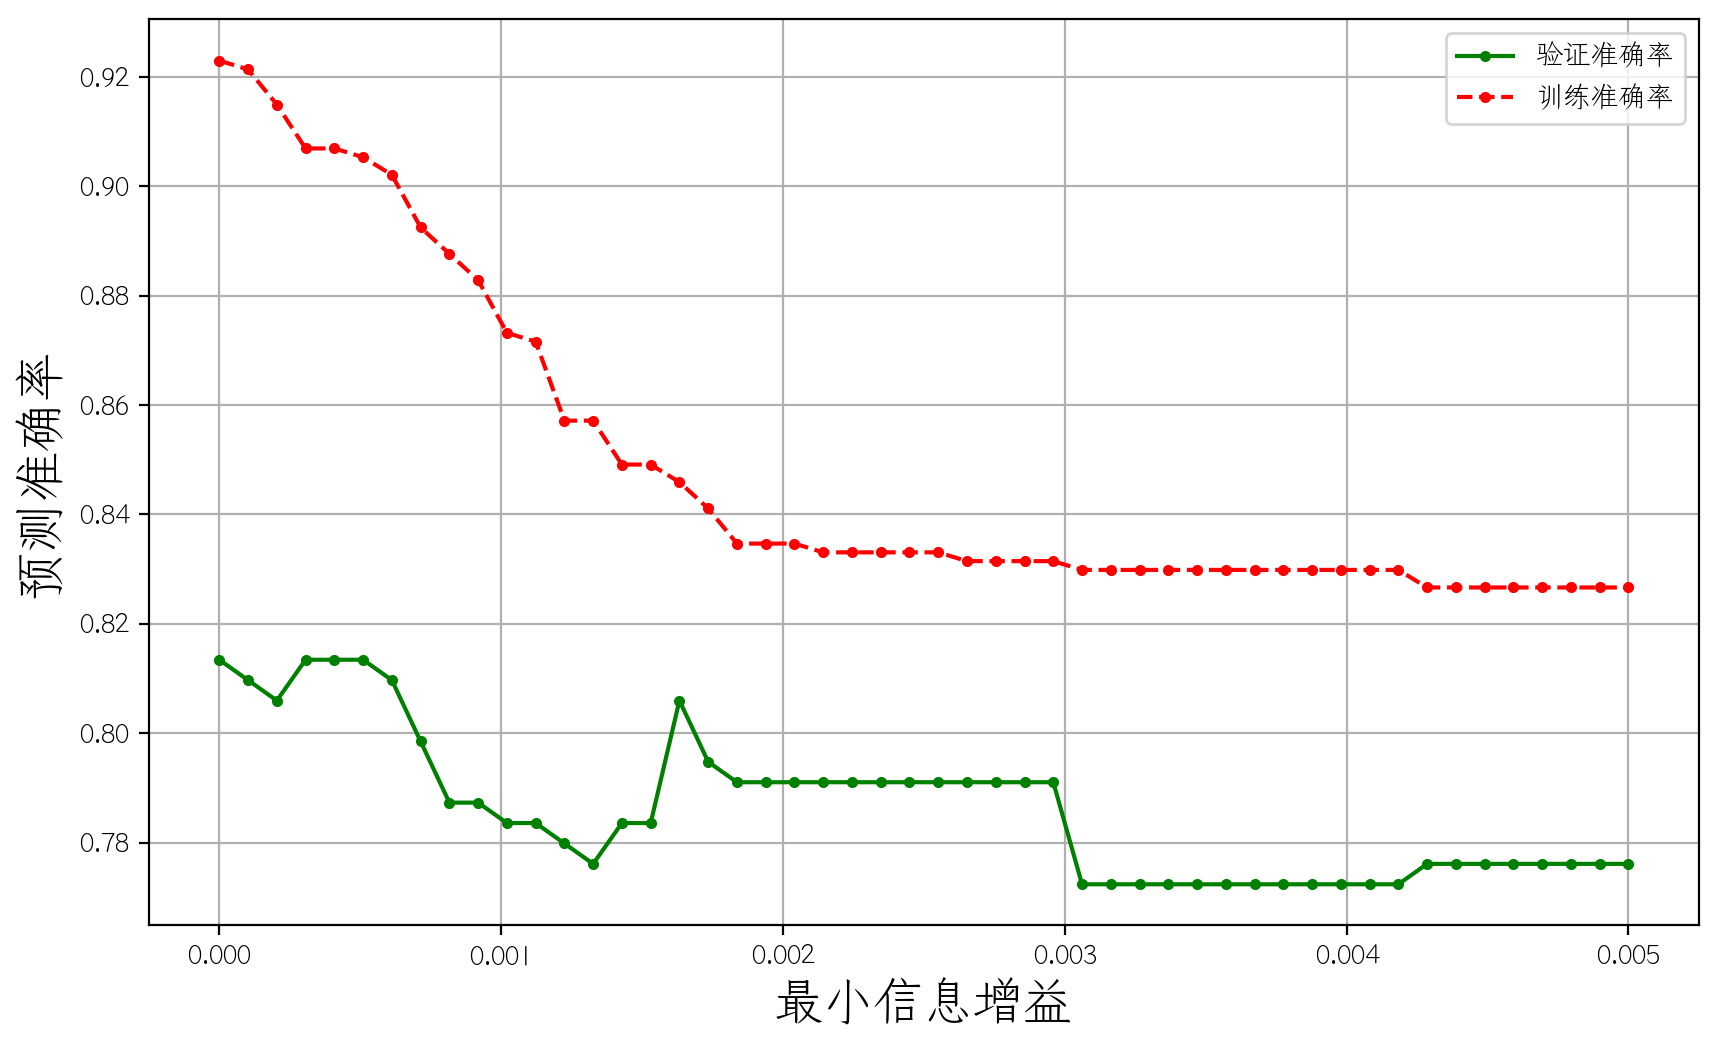

In [32]:
# 分离特征和class，训练集和测试集
trainValues, testValues, trainLabels, testLabels = train_test_split(originalDataSet[trainFeatures].values, originalDataSet[classLabel].values, test_size=0.3)


def minImpurityDecreaseTest(minImpurityDecrease):
    tree = DecisionTreeClassifier(criterion='gini', min_impurity_decrease=minImpurityDecrease)
    tree.fit(trainValues, trainLabels)
    trainScore = tree.score(trainValues, trainLabels)
    testScore = tree.score(testValues, testLabels)
    return trainScore, testScore

valueRange = np.linspace(0, 0.005, 50)
scores = [minImpurityDecreaseTest(value) for value in valueRange]
trainScores = [score[0] for score in scores]
testScores = [score[1] for score in scores]

# 输出最高训练准确率和最高验证准确率
maxTrainScoreIndex = np.argmax(trainScores)
maxTestScoreIndex = np.argmax(testScores)
maxTrainScore = trainScores[maxTrainScoreIndex]
maxTestScore = testScores[maxTestScoreIndex]
print('最高训练准确率: {:.02f}%，此时Min Impurity Decrease={:.05f} \n最高验证准确率: {:.02f}%，此时Min Impurity Decrease={:.05f}'.format
(maxTrainScore * 100, valueRange[maxTrainScoreIndex], maxTestScore * 100, valueRange[maxTestScoreIndex]))

# 绘制预测准确率随树的深度变化曲线
plt.rcParams['font.sans-serif'] = ['TsangerMingkai']

plt.figure(figsize=(10, 6), dpi=200)
plt.grid()
plt.xlabel('最小信息增益', fontsize=18)
plt.ylabel('预测准确率', fontsize=18)
plt.plot(valueRange, testScores, '.g-', label='验证准确率')
plt.plot(valueRange, trainScores, '.r--', label='训练准确率')
plt.legend()
plt.show()

最高训练准确率: 83.47%，此时Min Impurity Decrease=0.00000 
最高验证准确率: 80.22%，此时Min Impurity Decrease=0.00000


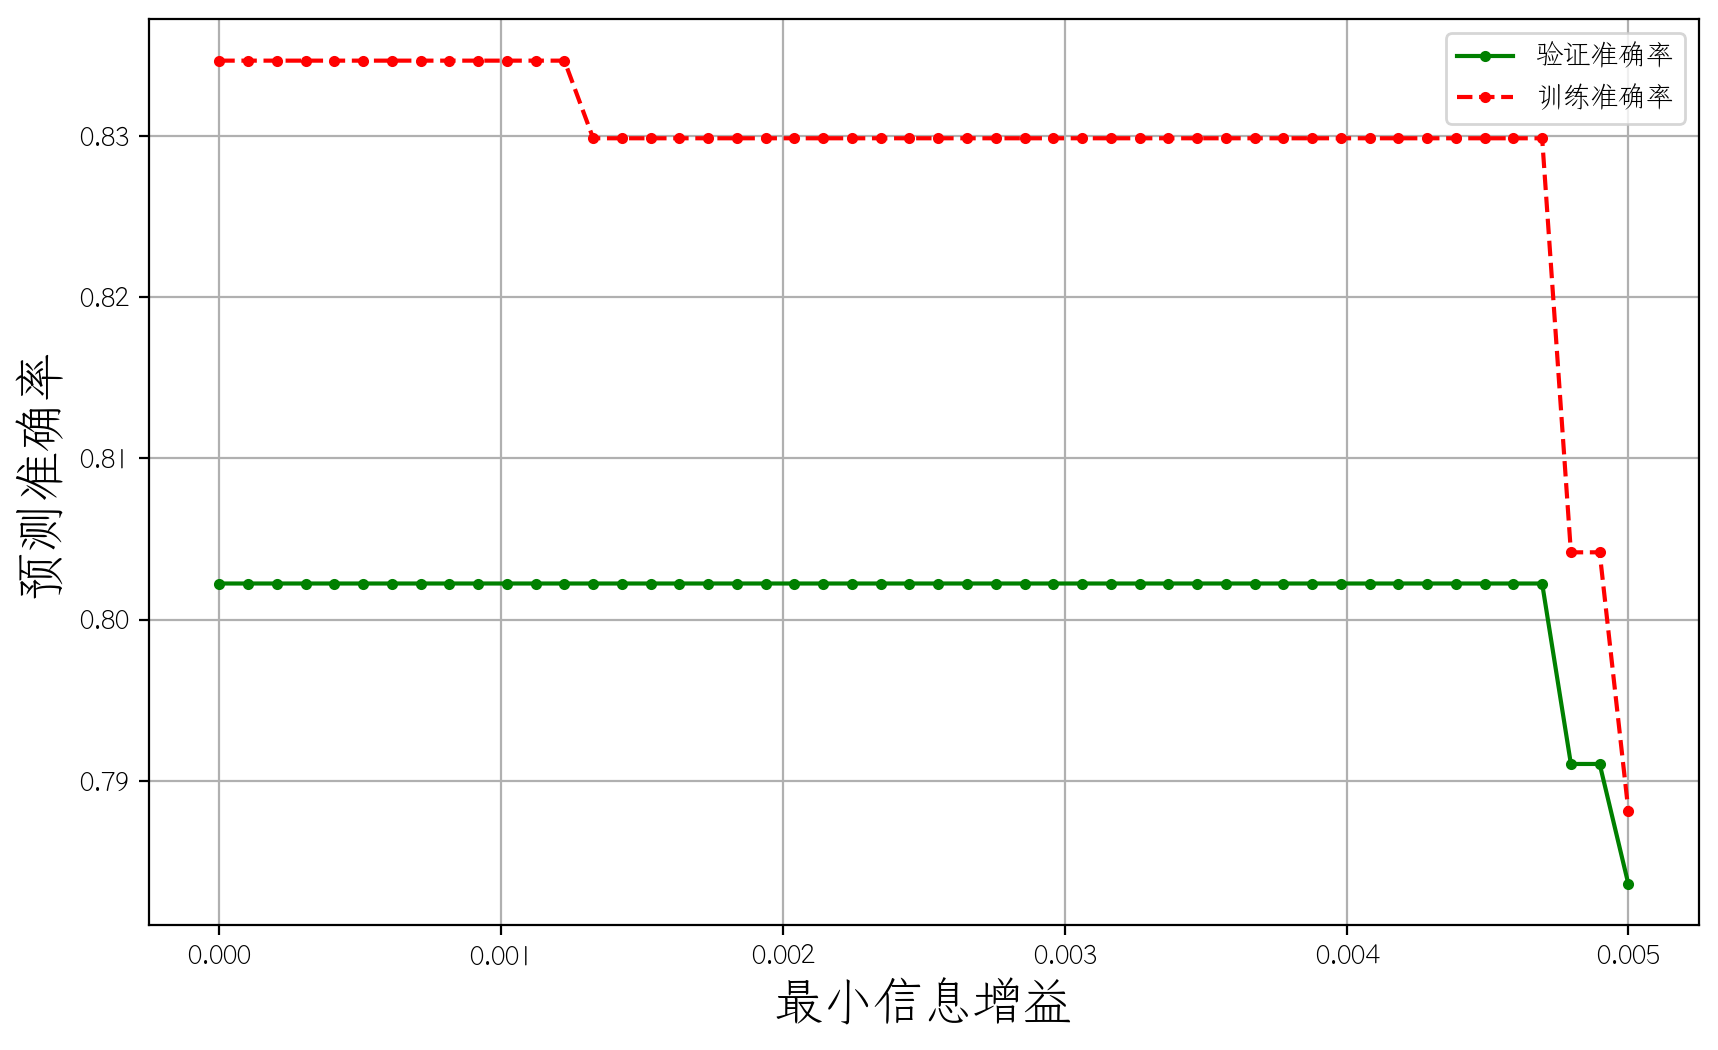

In [33]:
# 分离特征和class，训练集和测试集
trainValues, testValues, trainLabels, testLabels = train_test_split(trainDataSet[trainFeatures].values, trainDataSet[classLabel].values, test_size=0.3)


def minImpurityDecreaseTest(minImpurityDecrease):
    tree = DecisionTreeClassifier(criterion='gini', min_impurity_decrease=minImpurityDecrease)
    tree.fit(trainValues, trainLabels)
    trainScore = tree.score(trainValues, trainLabels)
    testScore = tree.score(testValues, testLabels)
    return trainScore, testScore

valueRange = np.linspace(0, 0.005, 50)
scores = [minImpurityDecreaseTest(value) for value in valueRange]
trainScores = [score[0] for score in scores]
testScores = [score[1] for score in scores]

# 输出最高训练准确率和最高验证准确率
maxTrainScoreIndex = np.argmax(trainScores)
maxTestScoreIndex = np.argmax(testScores)
maxTrainScore = trainScores[maxTrainScoreIndex]
maxTestScore = testScores[maxTestScoreIndex]
print('最高训练准确率: {:.02f}%，此时Min Impurity Decrease={:.05f} \n最高验证准确率: {:.02f}%，此时Min Impurity Decrease={:.05f}'.format
      (maxTrainScore * 100, valueRange[maxTrainScoreIndex], maxTestScore * 100, valueRange[maxTestScoreIndex]))

# 绘制预测准确率随树的深度变化曲线
plt.rcParams['font.sans-serif'] = ['TsangerMingkai']

plt.figure(figsize=(10, 6), dpi=200)
plt.grid()
plt.xlabel('最小信息增益', fontsize=18)
plt.ylabel('预测准确率', fontsize=18)
plt.plot(valueRange, testScores, '.g-', label='验证准确率')
plt.plot(valueRange, trainScores, '.r--', label='训练准确率')
plt.legend()
plt.show()

In [34]:
# 绘制曲线
def plotCurve(trainSizes, cvResults, xLabel, ax):
    # 获取平均准确率和均方差
    trainScoresMean = cvResults['mean_train_score']
    trainScoresStd = cvResults['std_train_score']
    testScoresMean = cvResults['mean_test_score']
    testScoresStd = cvResults['std_test_score']

    # 创建画布
    ax.set_title('parameters turning')
    ax.grid()
    ax.set_xlabel(xLabel)
    ax.set_ylabel('准确率')

    # 绘制训练准确度的随Gini阈值的变化和浮动区间
    ax.plot(
        trainSizes,
        trainScoresMean,
        '.--',
        color='#39AEA9',
        label='训练准确率',
    )
    ax.fill_between(
        trainSizes,
        trainScoresMean - trainScoresStd,
        trainScoresMean + trainScoresStd,
        alpha=0.3,
        color='#39AEA9',
    )

    # 绘制验证准确度的随Gini阈值的变化和浮动区间
    ax.plot(
        trainSizes,
        testScoresMean,
        '.-',
        color='#A2D5AB',
        label='交叉验证准确率',
    )
    ax.fill_between(
        trainSizes,
        testScoresMean - testScoresStd,
        testScoresMean + testScoresStd,
        alpha=0.3,
        color='#A2D5AB',
    )

    # 绘制图例
    ax.legend()


使用未经离散化的数据预测：
最高准确率下的参数: 
min_impurity_decrease: 0.001633
best score: 80.7%
----------------------------------------
使用离散化的数据预测：
最高准确率下的参数: 
min_impurity_decrease: 0.003980
best score: 83.3%


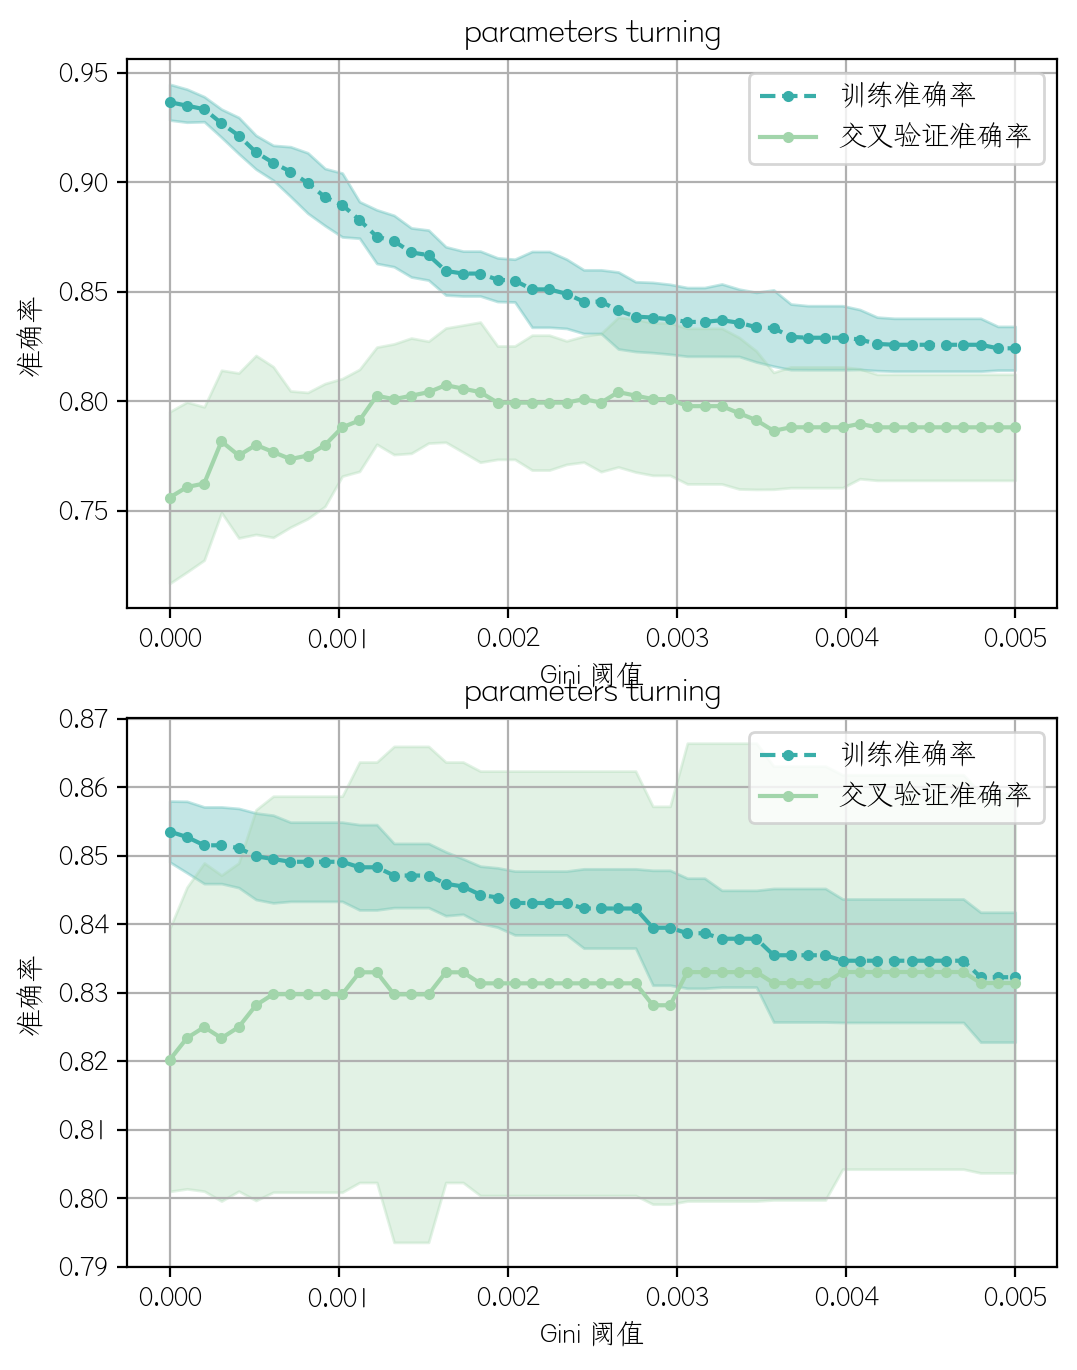

In [35]:
from sklearn.model_selection import GridSearchCV

# 绘制：未经过离散化处理的数据集进行预测随Gini Threshold的变化
fig, (ax1, ax2,) = plt.subplots(2, 1, figsize=(6, 8), dpi=200)

# 分离特征和class，训练集和测试集
trainValues, testValues, trainLabels, testLabels = train_test_split(originalDataSet[trainFeatures].values, originalDataSet[classLabel].values, test_size=0.3)

# 阈值取值范围，构建参数字典
giniThresholds = np.linspace(0, 0.005, 50)
paramGrid = {
    'min_impurity_decrease':giniThresholds,
}

# 多次按照不同的参数进行验证
model = GridSearchCV(DecisionTreeClassifier(), paramGrid, cv=5, return_train_score=True)
model.fit(trainValues, trainLabels)

# 输出最高的准确率和该准确率下的参数
print('使用未经离散化的数据预测：')
print("最高准确率下的参数: \n{0}: {1:.06f}\nbest score: {2:.01f}%".format(list(model.best_params_.keys())[0], model.best_params_[list(model.best_params_.keys())[0]], model.best_score_ * 100))

# 绘制图像
plotCurve(giniThresholds, model.cv_results_, xLabel='Gini 阈值', ax=ax1)

# 分离特征和class，训练集和测试集
trainValues, testValues, trainLabels, testLabels = train_test_split(trainDataSet[trainFeatures].values, originalDataSet[classLabel].values, test_size=0.3)

# 阈值取值范围，构建参数字典
giniThresholds = np.linspace(0, 0.005, 50)
paramGrid = {
    'min_impurity_decrease':giniThresholds,
}

# 多次按照不同的参数进行验证
model = GridSearchCV(DecisionTreeClassifier(), paramGrid, cv=5, return_train_score=True)
model.fit(trainValues, trainLabels)

# 输出最高的准确率和该准确率下的参数
print('----------------------------------------')
print('使用离散化的数据预测：')
print("最高准确率下的参数: \n{0}: {1:.06f}\nbest score: {2:.01f}%".format(list(model.best_params_.keys())[0], model.best_params_[list(model.best_params_.keys())[0]], model.best_score_ * 100))

# 绘制图像
plotCurve(giniThresholds, model.cv_results_, xLabel='Gini 阈值', ax=ax2)

对未经离散化的数据进行预测：
最高准确率下的参数: 
max_depth: 8
min_impurity_decrease: 0.001429
best score: 83.6%
对离散化的数据进行预测：
最高准确率下的参数: 
max_depth: 5
min_impurity_decrease: 0.000714
best score: 82.2%


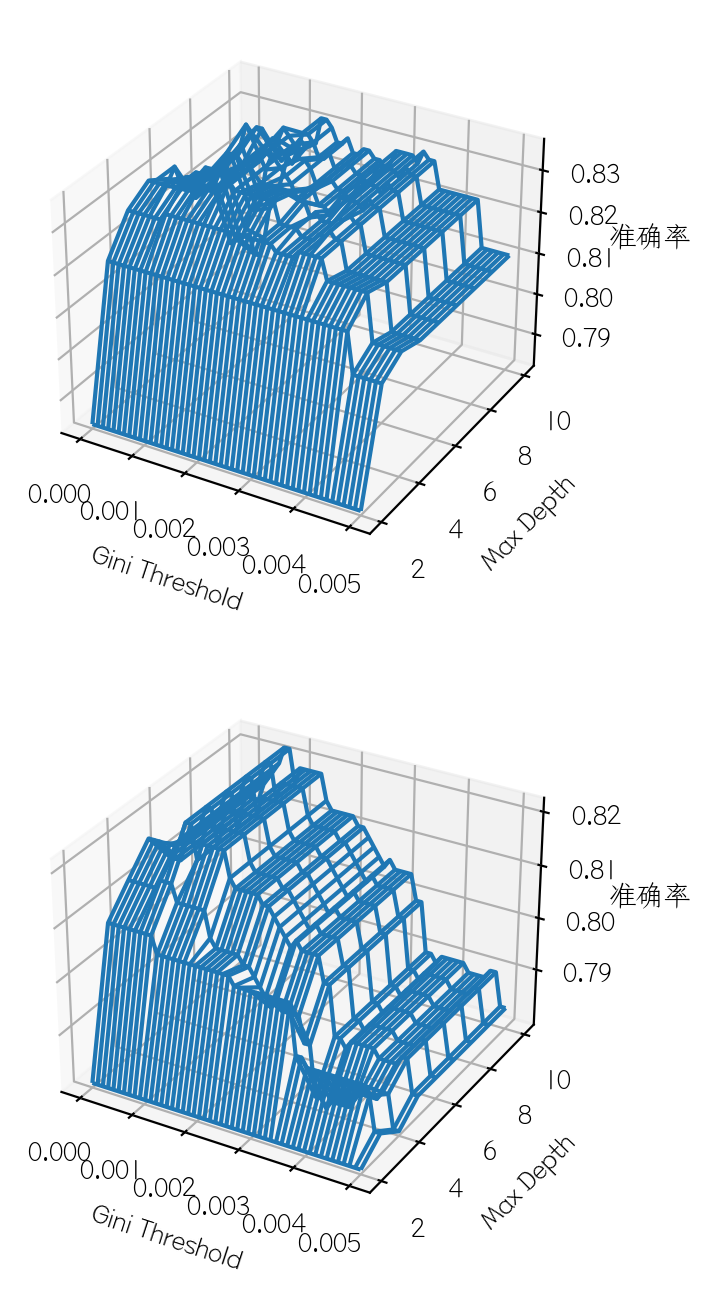

In [36]:
from matplotlib import cm

def curve3DPlot(ax, model, maxDepthRange, giniThresholds):

    # 输出最高的准确率和该准确率下的参数
    bestParameters = model.best_params_
    bestParameterKeys = list(bestParameters.keys())
    print("最高准确率下的参数: \n{0}: {1:.0f}\n{2}: {3:.06f}\nbest score: {4:.01f}%".format(bestParameterKeys[0], bestParameters[bestParameterKeys[0]], bestParameterKeys[1], bestParameters[bestParameterKeys[1]], model.best_score_ * 100))

    scores = model.cv_results_['mean_test_score'].reshape(9, -1).T

    giniThresholds, maxDepthRange = np.meshgrid(maxDepthRange, giniThresholds)
    ax.plot_wireframe(maxDepthRange, giniThresholds, scores, cmap=cm.coolwarm)
    ax.set_xlabel('Gini Threshold')
    ax.set_ylabel('Max Depth')
    ax.set_zlabel('准确率')

# 绘制：未经过离散化处理的数据集进行预测随Gini Threshold的变化
fig, (ax1, ax2,) = plt.subplots(2, 1, figsize=(6, 8), dpi=200, subplot_kw={"projection": "3d"})

# 分离特征和class，训练集和测试集
trainValues, testValues, trainLabels, testLabels = train_test_split(originalDataSet[trainFeatures].values, originalDataSet[classLabel].values, test_size=0.3)

# 设置参数网格
giniThresholds = np.linspace(0, 0.005, 50)
maxDepthRange = np.linspace(2, 10, 9)
paramGrid = {
    'min_impurity_decrease':giniThresholds,
    'max_depth':maxDepthRange,
}

# 构建多参数模型
model = GridSearchCV(DecisionTreeClassifier(), param_grid=paramGrid, cv=10, return_train_score=True)
model.fit(trainValues, trainLabels)
print('对未经离散化的数据进行预测：')
curve3DPlot(ax1, model, maxDepthRange, giniThresholds)

# 分离特征和class，训练集和测试集
trainValues, testValues, trainLabels, testLabels = train_test_split(trainDataSet[trainFeatures].values, originalDataSet[classLabel].values, test_size=0.3)

# 设置参数网格
giniThresholds = np.linspace(0, 0.005, 50)
maxDepthRange = np.linspace(2, 10, 9)
paramGrid = {
    'min_impurity_decrease':giniThresholds,
    'max_depth':maxDepthRange,
}

# 构建多参数模型
model = GridSearchCV(DecisionTreeClassifier(), param_grid=paramGrid, cv=10, return_train_score=True)
model.fit(trainValues, trainLabels)
print('对离散化的数据进行预测：')
curve3DPlot(ax2, model, maxDepthRange, giniThresholds)

plt.show()

In [139]:
from sklearn.model_selection import GridSearchCV

# 分离特征和class，训练集和测试集
trainValues, testValues, trainLabels, testLabels = train_test_split(originalDataSet[trainFeatures].values, originalDataSet[classLabel].values, test_size=0.3)

entropyThresholds = np.linspace(0, 0.005, 50)
giniThresholds = np.linspace(0, 0.005, 50)
maxDepthRange = np.linspace(2, 10, 9).astype(int)
minSamplesSplit = np.linspace(2, 30, 29).astype(int)

# Set the parameters by cross-validation
param_grid = [{'criterion': ['entropy'],
               'min_impurity_decrease': entropyThresholds},
              {'criterion': ['gini'],
               'min_impurity_decrease': giniThresholds},
              {'max_depth': maxDepthRange},
              {'min_samples_split': minSamplesSplit}]

model = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=10, return_train_score=True)
model.fit(trainValues, trainLabels)

print("最高准确率下的参数: \n{0}\nbest score: {1:.01f}%".format(model.best_params_, model.best_score_ * 100))

最高准确率下的参数: 
{'criterion': 'entropy', 'min_impurity_decrease': 0.004693877551020408}
best score: 83.2%


In [40]:
# 生成最优决策树图形

# 使用GridSearchCV计算最优参数
# 分离特征和class，训练集和测试集
trainValues, testValues, trainLabels, testLabels = train_test_split(trainDataSet[trainFeatures].values, originalDataSet[classLabel].values, test_size=0.3)

# 设置参数网格
criterionType = ['entropy', 'gini']
giniThresholds = np.linspace(0, 0.005, 50)
maxDepthRange = np.linspace(2, 10, 9).astype(int)
minSamplesSplit = np.linspace(2, 30, 29).astype(int)

paramGrid = {
    'criterion':criterionType,
    'min_impurity_decrease':giniThresholds,
    'max_depth':maxDepthRange,
    'min_samples_split':minSamplesSplit,
}

# 构建多参数模型
model = GridSearchCV(DecisionTreeClassifier(), param_grid=paramGrid, cv=10, return_train_score=True)
model.fit(trainValues, trainLabels)

bestParams = model.best_params_

print('最高准确率模型的参数：\ncriterion: {}\nmax_depth: {}\nmin_impurity_decrease: {}\nmin_samples_split: {}\n'.format(bestParams['criterion'], bestParams['max_depth'], bestParams['min_impurity_decrease'], bestParams['min_samples_split']))

最高准确率模型的参数：
criterion: gini
max_depth: 5
min_impurity_decrease: 0.004285714285714286
min_samples_split: 2



In [191]:
from sklearn.tree import export_graphviz

tree = DecisionTreeClassifier(criterion=bestParams['criterion'], min_impurity_decrease=bestParams['min_impurity_decrease'], max_depth=bestParams['max_depth'], min_samples_split=bestParams['min_samples_split'])
tree.fit(trainValues, trainLabels)

trainScore = tree.score(trainValues, trainLabels)
testScore = tree.score(testValues, testLabels)
print('最优模型表现：')
print('训练准确率：{:.02f}'.format(trainScore * 100))
print('验证准确率：{:.02f}'.format(testScore * 100))

with open('titanic.dot', 'w+') as f:
    f = export_graphviz(tree, out_file=f)

最优模型表现：
训练准确率：82.02
验证准确率：81.72


In [ ]:
import graphviz

In [41]:
with open('titanic.dot', 'r+') as f:
    treeData = f.read()
treeGraph = graphviz.Source(treeData)
treeGraph.render('Decision_Tree')

'Decision_Tree.pdf'

In [194]:
from sklearn.tree import export_text

treeText = export_text(tree)
with open('Decision_Tree.txt', 'w+') as f:
    f.write(treeText)
    print(treeText)

|--- feature_1 <= 0.50
|   |--- feature_0 <= 2.50
|   |   |--- feature_2 <= 1.50
|   |   |   |--- class: 1
|   |   |--- feature_2 >  1.50
|   |   |   |--- feature_4 <= 0.50
|   |   |   |   |--- class: 1
|   |   |   |--- feature_4 >  0.50
|   |   |   |   |--- class: 1
|   |--- feature_0 >  2.50
|   |   |--- feature_3 <= 0.50
|   |   |   |--- feature_2 <= 1.50
|   |   |   |   |--- feature_2 <= 0.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- feature_2 >  0.50
|   |   |   |   |   |--- class: 1
|   |   |   |--- feature_2 >  1.50
|   |   |   |   |--- class: 0
|   |   |--- feature_3 >  0.50
|   |   |   |--- feature_4 <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- feature_4 >  0.50
|   |   |   |   |--- class: 0
|--- feature_1 >  0.50
|   |--- feature_2 <= 0.50
|   |   |--- feature_0 <= 2.50
|   |   |   |--- feature_4 <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- feature_4 >  0.50
|   |   |   |   |--- feature_0 <= 1.50
|   |   |   |   |   |--- class: 1
|   |   |   |

最优模型表现：
训练准确率：82.02
验证准确率：81.72


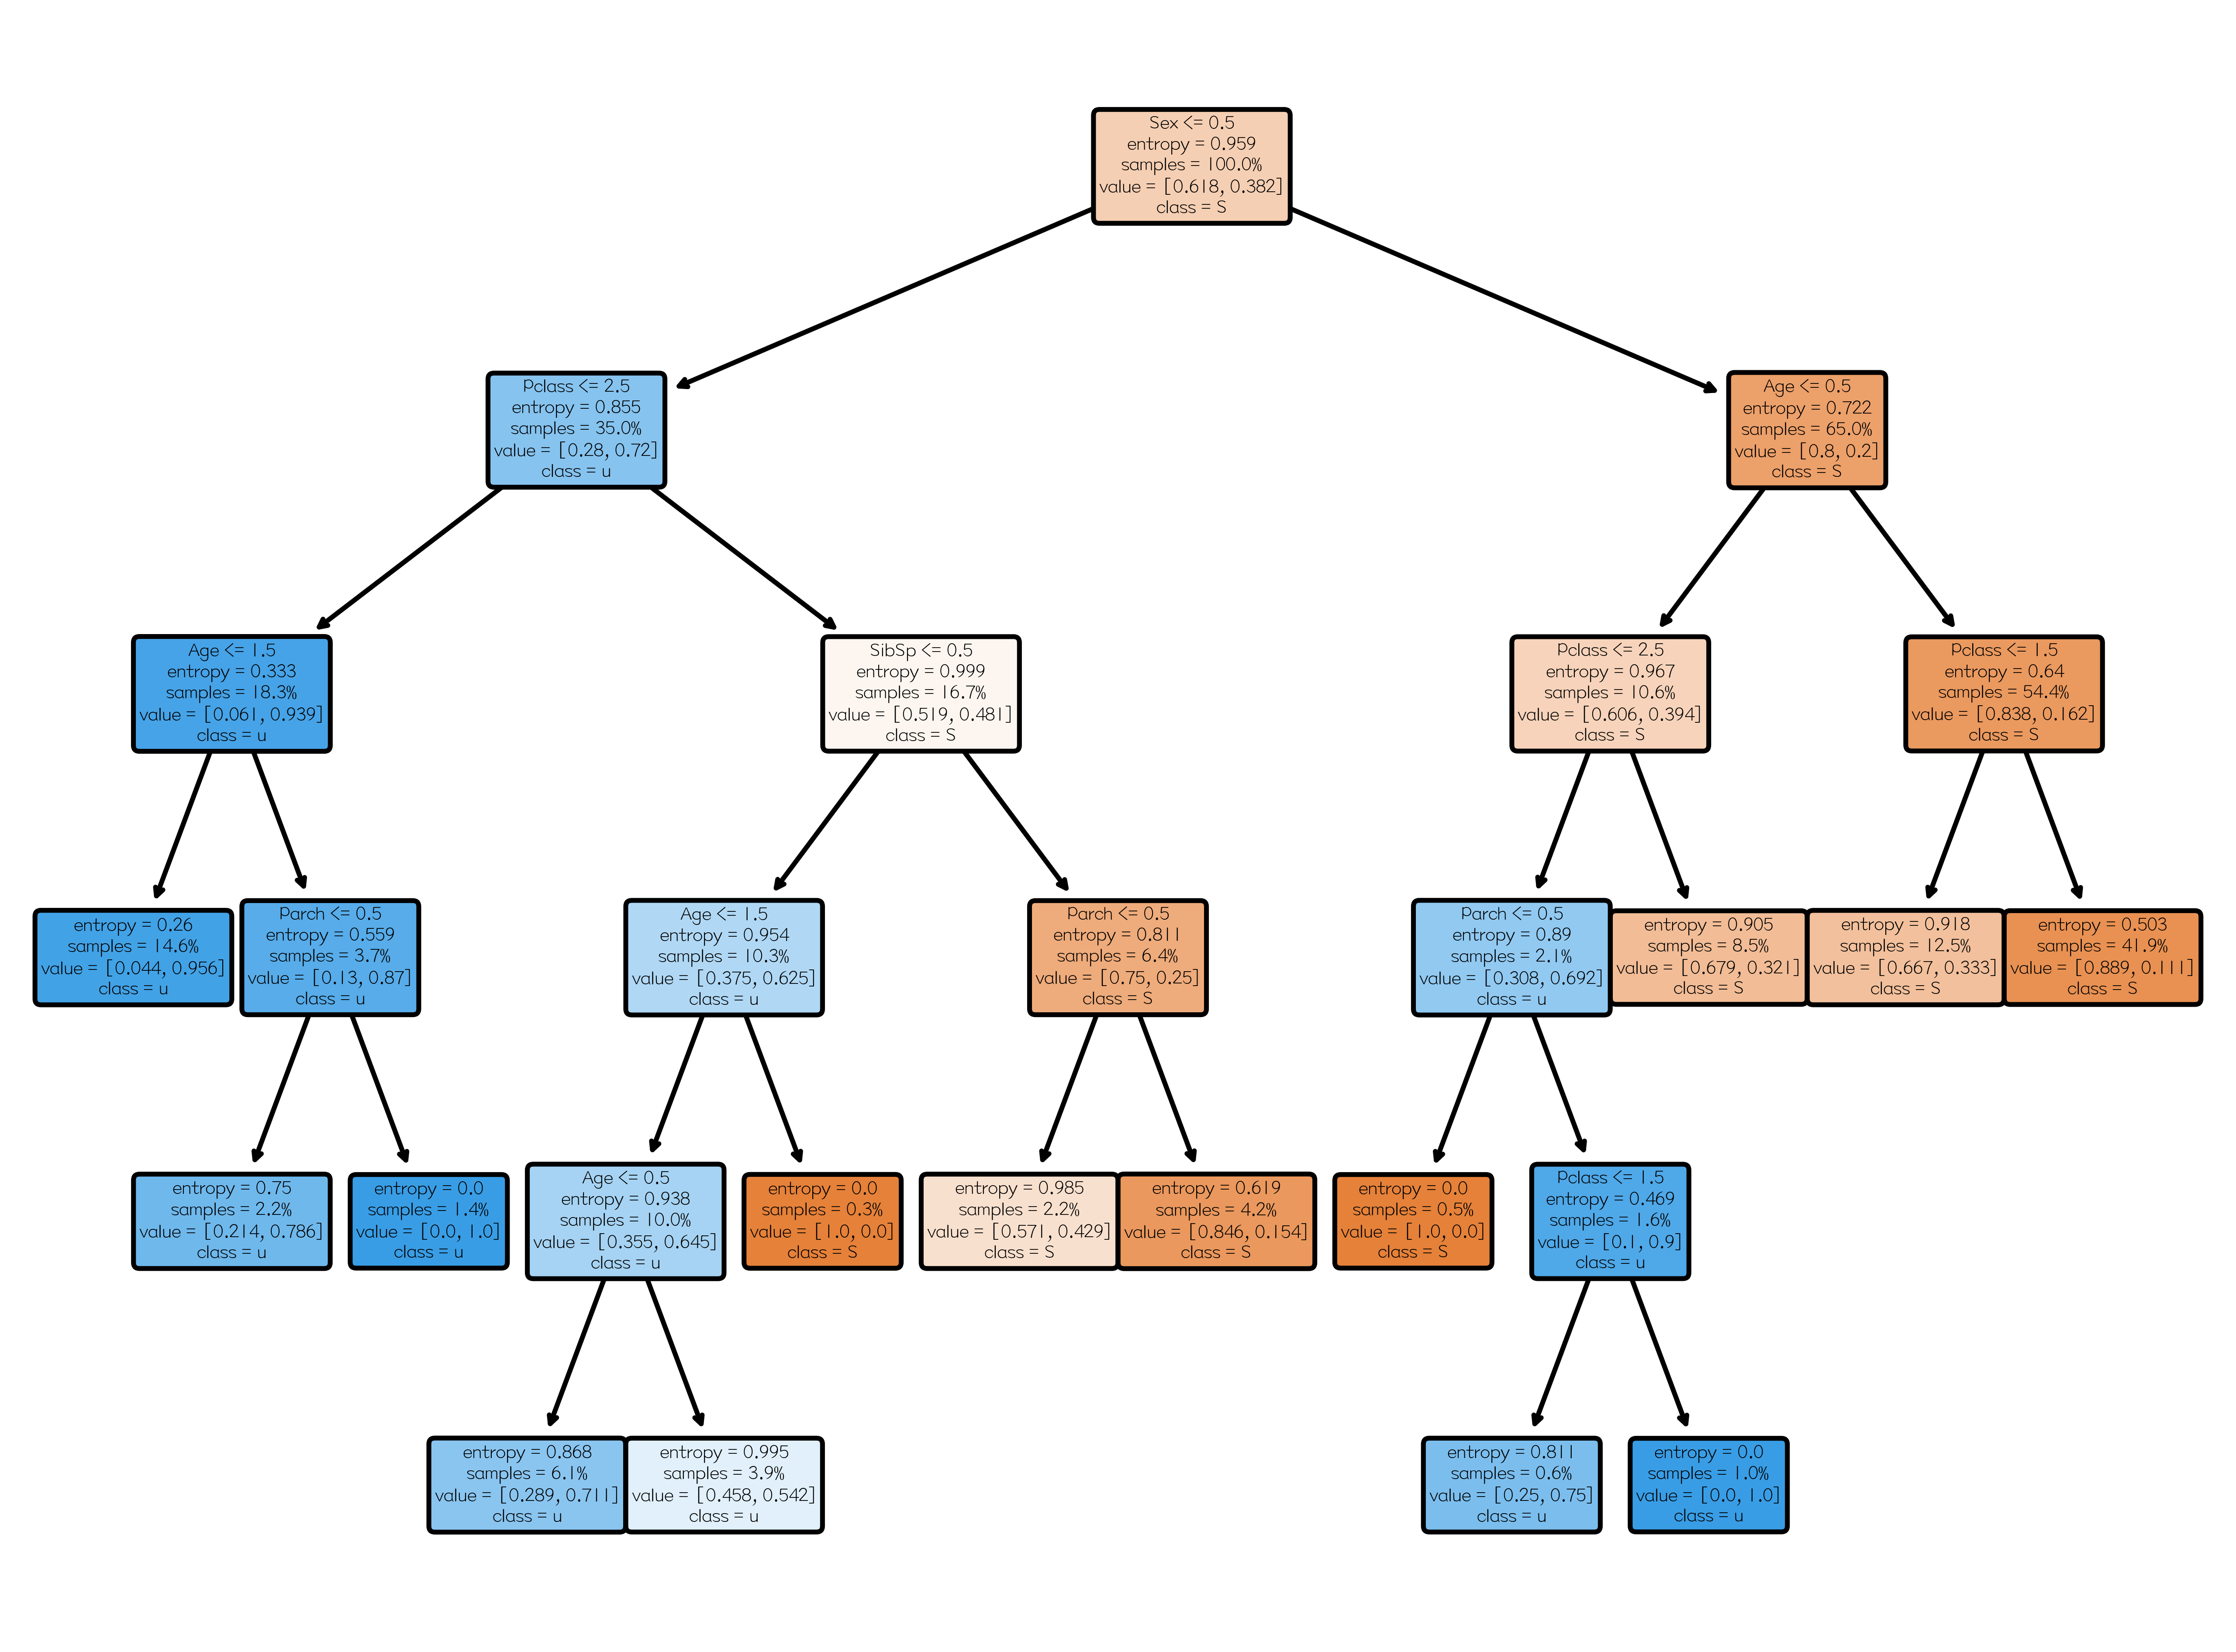

In [185]:
from sklearn.tree import plot_tree

tree = DecisionTreeClassifier(criterion=bestParams['criterion'], min_impurity_decrease=bestParams['min_impurity_decrease'], max_depth=bestParams['max_depth'], min_samples_split=bestParams['min_samples_split'])
tree.fit(trainValues, trainLabels)

trainScore = tree.score(trainValues, trainLabels)
testScore = tree.score(testValues, testLabels)
print('最优模型表现：')
print('训练准确率：{:.02f}'.format(trainScore * 100))
print('验证准确率：{:.02f}'.format(testScore * 100))

featureNames = trainDataSet.columns.tolist()[:-1]
classNames = trainDataSet.columns.tolist()[-1]

plt.figure(figsize=(8, 6), dpi=800)
plot_tree(tree, feature_names=featureNames, class_names=classNames, filled=True, impurity=True, proportion=True, rounded=True)
plt.show()